In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

FOLDERNAME = 'ML/KRembedding/'

LIB_PATH = 'lib'
DATA_PATH = '/notebooks/embedding/data/'

%cd drive/My\ Drive/$FOLDERNAME/

# 학습된 단어 임베딩 다운로드
!bash preprocess.sh dump-word-embeddings

Mounted at /content/drive
/content/drive/My Drive/ML/KRembedding
download word embeddings...
--2021-05-30 11:18:36--  https://docs.google.com/uc?export=download&confirm=uJOZ&id=1FeGIbSz2E1A63JZP_XIxnGaSRt7AhXFf
Resolving docs.google.com (docs.google.com)... 142.250.107.139, 142.250.107.100, 142.250.107.102, ...
Connecting to docs.google.com (docs.google.com)|142.250.107.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-8k-docs.googleusercontent.com/docs/securesc/juqe1pu6esa1ebgliqupqpf7oa9rj5pm/qf6k3b71qi9g65eacj18rassra3arn0f/1622373450000/05170634686643261154/08727770283154796214Z/1FeGIbSz2E1A63JZP_XIxnGaSRt7AhXFf?e=download [following]
--2021-05-30 11:18:36--  https://doc-08-8k-docs.googleusercontent.com/docs/securesc/juqe1pu6esa1ebgliqupqpf7oa9rj5pm/qf6k3b71qi9g65eacj18rassra3arn0f/1622373450000/05170634686643261154/08727770283154796214Z/1FeGIbSz2E1A63JZP_XIxnGaSRt7AhXFf?e=download
Resolving doc-08-8k-docs.googleuserconten

In [2]:
# Mecab 설치
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Installing automake (A dependency for mecab-ko)
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:8 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [60.9 kB]
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
Get:11 https://developer.down

In [2]:
import sys
sys.path.append('/content/drive/MyDrive/'+FOLDERNAME+LIB_PATH)

## 4.7.2 단어 유사도 평가

In [3]:
!wget https://github.com/dongjun-Lee/kor2vec/raw/master/test_dataset/kor_ws353.csv -P $DATA_PATH/raw

--2021-05-30 11:21:59--  https://github.com/dongjun-Lee/kor2vec/raw/master/test_dataset/kor_ws353.csv
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dongjun-Lee/kor2vec/master/test_dataset/kor_ws353.csv [following]
--2021-05-30 11:21:59--  https://raw.githubusercontent.com/dongjun-Lee/kor2vec/master/test_dataset/kor_ws353.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6753 (6.6K) [text/plain]
Saving to: ‘/notebooks/embedding/data//raw/kor_ws353.csv’

kor_ws353.csv       100%[===================>]   6.59K  --.-KB/s    in 0s      

2021-05-30 11:21:59 (59.4 MB/s) - ‘/notebooks/embedding/

In [13]:
from models.word_eval import WordEmbeddingEvaluator

def get_model(model_name):
  if model_name == 'word2vec':
    return WordEmbeddingEvaluator(
        vecs_txt_fname=DATA_PATH+'word-embeddings/word2vec/word2vec',
        method='word2vec', dim=100, tokenizer_name='mecab')
  elif model_name == 'fasttext':
    return WordEmbeddingEvaluator(
        vecs_txt_fname=DATA_PATH+'word-embeddings/fasttext/fasttext.vec',
        vecs_bin_fname=DATA_PATH+'word-embeddings/fasttext/fasttext.bin',
        method='fasttext', dim=100, tokenizer_name='mecab')
  elif model_name == 'glove':
    return WordEmbeddingEvaluator(
        vecs_txt_fname=DATA_PATH+'word-embeddings/glove/glove.txt',
        method='glove', dim=100, tokenizer_name='mecab')
  elif model_name == 'swivel':
    return WordEmbeddingEvaluator(
        vecs_txt_fname=DATA_PATH+'word-embeddings/swivel/row_embedding.tsv',
        method='swivel', dim=100, tokenizer_name='mecab')
  else:
    print('model name error!')

In [14]:
import numpy as np
import scipy.stats as st

model_corr = {}
for model_name in ['word2vec', 'fasttext', 'glove', 'swivel']:
  model = get_model(model_name)

  actual_sim_list, pred_sim_list = [], []
  missed = 0
  with open(DATA_PATH+'raw/kor_ws353.csv', 'r') as pairs:
    for pair in pairs:
      w1, w2, actual_sim = pair.strip().split(",")
      try:
        w1_vec = model.get_sentence_vector(w1)
        w2_vec = model.get_sentence_vector(w2)
        score = np.dot(w1_vec, w2_vec)
        actual_sim_list.append(float(actual_sim))
        pred_sim_list.append(score)
      except KeyError:
        missed += 1
  spearman, _ = st.spearmanr(actual_sim_list, pred_sim_list)
  pearson, _ = st.pearsonr(actual_sim_list, pred_sim_list)
  model_corr[model_name] = {'spearman': spearman, 'pearson': pearson}

In [20]:
import pandas as pd

mnames = model_corr.keys()
df = pd.DataFrame({
    'spearman': [ model_corr[m]['spearman'] for m in mnames ],
    'pearson': [ model_corr[m]['pearson'] for m in mnames ]
}, index=mnames)

(0.4, 0.6705486450174952)

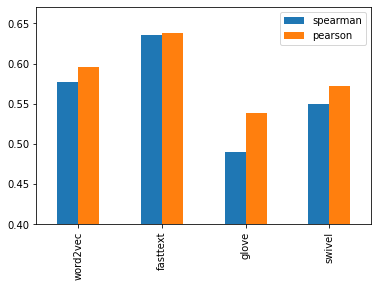

In [25]:
import matplotlib.pyplot as plt

ax = df.plot.bar()
ax.set_ylim(.4,)